In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# Взял файл, который скинула Акнур в ТГ
file_path = '/content/drive/MyDrive/Colab_Notebooks/ADNI_136_S_0579_MR_MPR_R_N3_Scaled_Br_20070215222116139_S16545_I40404.nii'

In [4]:
# Загрузка изображения
img = nib.load(file_path)

In [5]:
# Получение данных как NumPy массива (3D матрица)
data = img.get_fdata()  # тип float64 по умолчанию

print("Shape:", data.shape)         # (X, Y, Z)
print("Min value:", data.min())     # Проверка диапазона
print("Max value:", data.max())

Shape: (256, 256, 170)
Min value: 0.0
Max value: 2994.782470703125


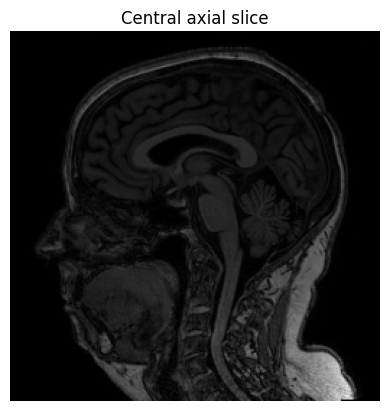

In [6]:
# Визуализация одного среза (например, по оси Z)
plt.imshow(data[:, :, data.shape[2] // 2], cmap="gray")
plt.title("Central axial slice")
plt.axis("off")
plt.show()

Обрезанный размер: (110, 170, 130)


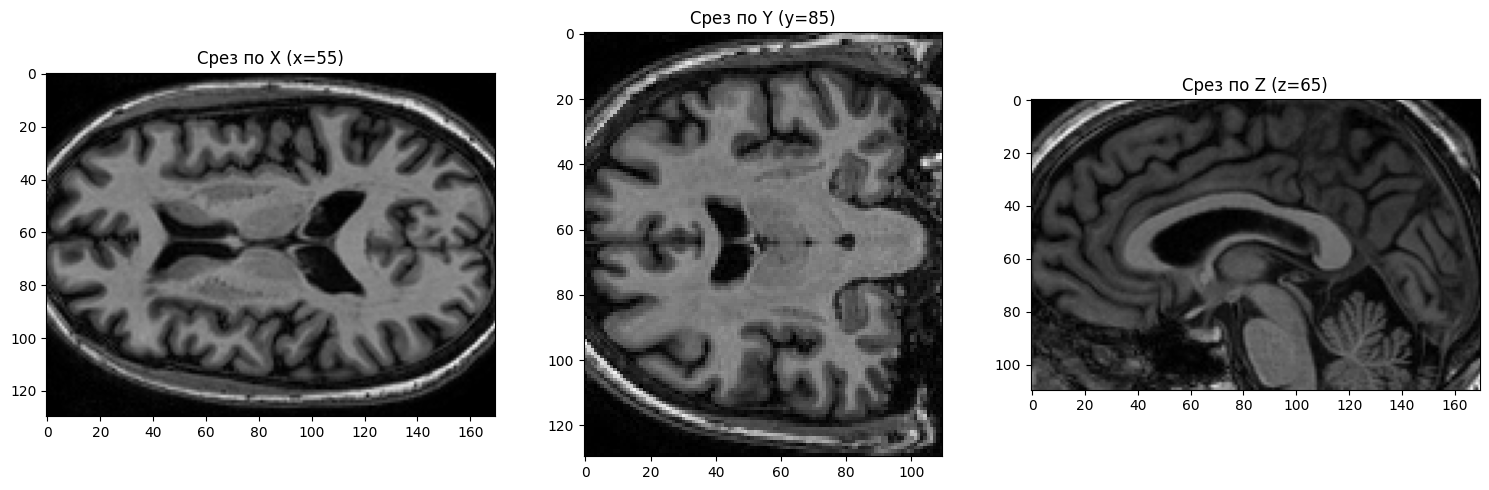

In [7]:
# Тут координаты нашего куба где мозг, координаты отобрал методом тыка
x_min, x_max = 30, 140
y_min, y_max = 50, 220
z_min, z_max = 20, 150

# Обрезаем изображение по найденным координатам
cropped_data = data[x_min:x_max, y_min:y_max, z_min:z_max]

# Проверим размер после обрезки
print(f"Обрезанный размер: {cropped_data.shape}")

# Размеры данных
x_center = cropped_data.shape[0] // 2
y_center = cropped_data.shape[1] // 2
z_center = cropped_data.shape[2] // 2

# Визуализация всех трех ортогональных срезов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Срез по оси X (вид сбоку: Y vs Z)
axes[0].imshow(cropped_data[x_center, :, :].T, cmap='gray')
axes[0].set_title(f'Срез по X (x={x_center})')

# Срез по оси Y (вид спереди: X vs Z)
axes[1].imshow(cropped_data[:, y_center, :].T, cmap='gray')
axes[1].set_title(f'Срез по Y (y={y_center})')

# Срез по оси Z (вид сверху: X vs Y)
axes[2].imshow(cropped_data[:, :, z_center], cmap='gray')
axes[2].set_title(f'Срез по Z (z={z_center})')

plt.tight_layout()
plt.show()

In [8]:
# Перевод из Numpy массива в nii формат
cropped_img = nib.Nifti1Image(cropped_data, affine=img.affine)
# Сохранение. У меня тут Collab поэтому сохраняется в виртуальную среду, на компе должно рядом с файликом сохраниться
nib.save(cropped_img, 'cropped_img.nii.gz')
# Скачаивание из Collab
files.download('cropped_img.nii')

FileNotFoundError: Cannot find file: cropped_img.nii

In [9]:
import pickle
import pandas as pd
# сериализуем массив
packed = pickle.dumps(cropped_data)

# От балды ID пациента и тяжесть болезни
subject_id = 'subject_001'
severity = 2

df = pd.DataFrame([{
    'id': subject_id,
    'severity': severity,
    'image_data': packed
}])

In [ ]:
# Сохранение в csv формат, получился у меня очень тяжелый файлик
df.to_csv("dataset.csv", index=False)
files.download('dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Сериализуем, тут получше вышло
df.to_pickle("dataset.pkl")
files.download('dataset.pkl')

In [10]:
# Самый наилучший вариант как по мне, из 42 мб изначального файла вышло 9
df.to_parquet("dataset.parquet", compression="brotli")
files.download('dataset.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
def downgrade_dtype(byte_data):
    arr = np.frombuffer(byte_data, dtype=np.float32)  # если ты сериализовал как float32
    arr = arr.astype(np.float16)
    return arr.tobytes()

df['image_data'] = df['image_data'].apply(downgrade_dtype)

In [16]:
# Самый наилучший вариант как по мне, из 42 мб изначального файла вышло 2 мб
df.to_parquet("dataset.parquet", compression="brotli")
files.download('dataset.parquet')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>